In [1]:
import numpy as np
import sys
import os
import open3d as o3d
import pandas as pd
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
from itertools import combinations, combinations_with_replacement

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.ResidueDepth import get_surface

import matplotlib.pyplot as plt
import seaborn as sn

import matplotlib.cm as cm

from msms import SolventAccessible

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-01-13 10:51:52,298 - utils - NumExpr defaulting to 4 threads.


In [2]:
"""
deprecated method to show binding pocket shape
"""

def GridInPocket(AtomCoord):
    
    # 1.inital grid points
    X = np.arange(-16, 15, 1.375)
    Y = np.arange(-7, 7, 1.375)
    Z = np.arange(0, 10, 1.375)
    xx,yy,zz = np.meshgrid(X, Y, Z)
    grid_coord = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1),zz.reshape(-1,1)))

    # 2. protruding grid points
    box = Delaunay(AtomCoord)
    InGroove = box.find_simplex(grid_coord)>=0

    # 3. crash grid points
    # NoCrash = cdist(grid_coord, AtomCoord).min(axis=1) > 1.375
    
    return grid_coord[InGroove]

def ShowAtomCloud(DATFile, PDBfile):
    
    DAT = pd.read_csv(DATFile)
    Coord = DAT[['X', 'Y', 'Z']].values

    # parser = PDBParser(PERMISSIVE=1)
    Init_grid = GridInPocket(Coord)

    SA_calc = SolventAccessible()
    Grid = Init_grid[SA_calc.InorOut(Init_grid, PDBfile)]


    P1 = o3d.geometry.PointCloud()
    P2 = o3d.geometry.PointCloud()
    Indicator = o3d.geometry.PointCloud()
    
    P1.points = o3d.utility.Vector3dVector(Coord)
    P2.points = o3d.utility.Vector3dVector(Grid)
    Indicator.points = o3d.utility.Vector3dVector([[0,0,0],[20,0,0],[0,10,0]]) #show origin and axes

    # P1.colors = o3d.utility.Vector3dVector(color1)
    # P2.colors = o3d.utility.Vector3dVector(color2)

    P1.paint_uniform_color([1, 0, 0])
    P2.paint_uniform_color([0, 1, 0])
    Indicator.paint_uniform_color([0, 0, 1])
    o3d.visualization.draw_geometries([P1, P2, Indicator])

    return

ShowAtomCloud("../crystal/A_mean/DAT/A01_01.csv", "../crystal/A_mean/pdb/A01_01.pdb")

In [3]:
def shape_pocket(InDir, OutCSV):

    X = np.arange(-16, 15, 1.375)
    Y = np.arange(-7, 7, 1.375)
    Z = np.arange(0, 10, 1.375)
    xx,yy,zz = np.meshgrid(X, Y, Z)
    Init_grid = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1),zz.reshape(-1,1)))
    SA_calc = SolventAccessible()

    InPocket_list = []
    FileName_list = []

    for InPDB in os.listdir(InDir):
        if InPDB.endswith(".pdb"):
            InPocketGrid = SA_calc.InorOut(Init_grid, f"{InDir}/{InPDB}").astype(int) # 1-d array
            InPocket_list.append(InPocketGrid) # list of 1-d array, array from each molecule is a row
            FileName_list.append(InPDB.split(".")[0])

    InPocket_array = np.array(InPocket_list).T # each molecule is a row -> column
    # print(Init_grid)

    outdata = np.hstack((Init_grid, InPocket_array))
    outdf = pd.DataFrame(outdata, columns=["X", "Y", "Z"]+FileName_list)
    outdf.to_csv(OutCSV)

# shape_pocket("../crystal/A_mean/pdb", "../crystal/A_mean/Pocket_grid_shape_A.csv")
# shape_pocket("../crystal/B_mean/pdb", "../crystal/B_mean/Pocket_grid_shape_B.csv")

In [4]:
def diff_sum(arrayA, arrayB):
    """
    count how many grid points are different
    """
    diff = np.sum(np.abs(arrayA - arrayB))
    return diff

def Grid_dist(InCSV):
    """
    claculate the distance between pocket shape grids
    """
    Indf = pd.read_csv(InCSV)

    AlleleNames = Indf.columns[4:] # numpy array
    # AlleleComb_wi = combinations_with_replacement(AlleleNames, 2)
    AlleleComb_wo = combinations(AlleleNames, 2)

    DistMat = pd.DataFrame(np.zeros((len(AlleleNames), len(AlleleNames))), index=AlleleNames, columns=AlleleNames)

    # SimilarityMat = {}
    for comb in AlleleComb_wo:
        DistMat.loc[comb[1],comb[0]] = diff_sum(Indf[comb[0]], Indf[comb[1]]) # Distance matrix for output, in lower triangular form

    return DistMat

In [5]:
def heatmap(Mat, order=None, size=(10,10)):
    # Mat = pd.read_csv(InCSV, index_col=0)
    Mat = Mat.add(Mat.T, fill_value=0)
    # print(Mat.index)
    if order:
        split = np.cumsum([len(sublist) for sublist in order])
        # print(split)
        flat_order = [item for sublist in order for item in sublist]
        Mat = Mat[flat_order]
        Mat = Mat.reindex(flat_order)
    # print(Mat.index, Mat.columns)

    plt.figure(figsize=size, facecolor="w")
    
    sn.heatmap(Mat, square=True, xticklabels=True, yticklabels=True)
    for line in split[:-1]:
        plt.axhline(y=line, color='y', linestyle='-')
        plt.axvline(x=line, color='y', linestyle='-')
    plt.show()
    return

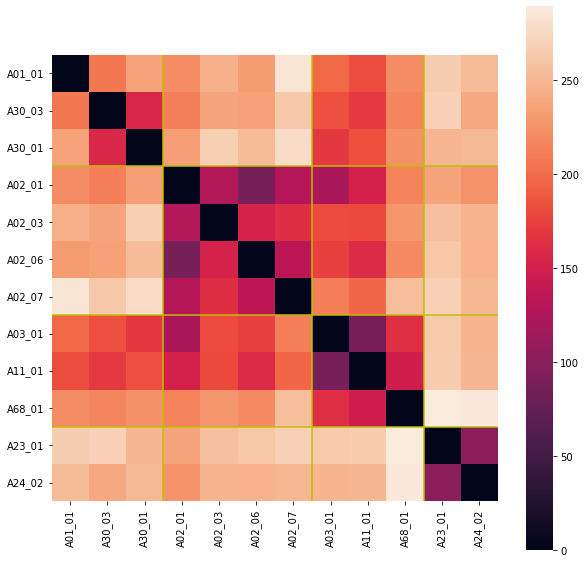

In [6]:
A_crystal_mean_order = [['A01_01', 'A30_03', 'A30_01'],
    ['A02_01', 'A02_03', 'A02_06', 'A02_07'],
    ['A03_01', 'A11_01', 'A68_01'],
    ['A23_01', 'A24_02']]

Mat = Grid_dist("../crystal/A_mean/Pocket_grid_shape_A.csv")
heatmap(Mat, A_crystal_mean_order)

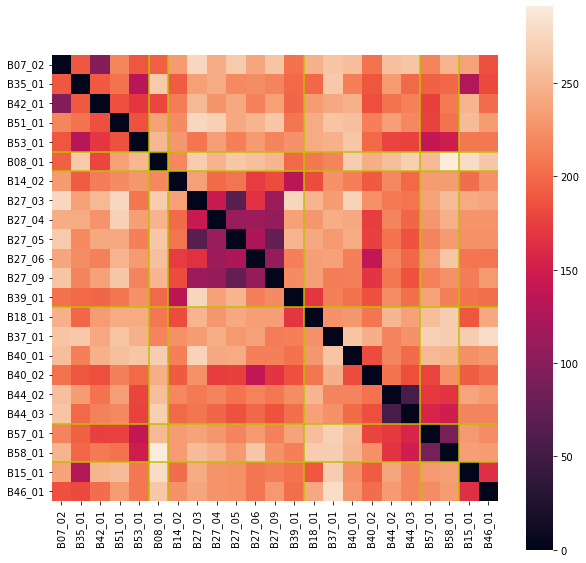

In [7]:
B_crystal_mean_order = [["B07_02","B35_01","B42_01","B51_01","B53_01"],
    ["B08_01"],
    ["B14_02","B27_03","B27_04","B27_05","B27_06","B27_09","B39_01"],
    ["B18_01","B37_01","B40_01","B40_02","B44_02","B44_03"],
    ["B57_01","B58_01"],
    ["B15_01","B46_01"]]

Mat = Grid_dist("../crystal/B_mean/Pocket_grid_shape_B.csv")
heatmap(Mat, B_crystal_mean_order)

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

def AvgOccupation(InArray):

    return np.mean(InArray, axis=1)

def save_shape_color(color_array, shape_array, file_name):
    """
    write rgb color code and grid coord to csv file, for visualization in pymol
    """
    # COLOR, r, g, b, SPHERE, x, y, z
    color_array = np.round(color_array, 2)
    nrows = color_array.shape[0]
    # COLOR_column = np.ones((nrows, 1), dtype=float) * 6.0
    # SPHERE_column = np.ones((nrows, 1), dtype=float) * 7.0
    COLOR_column = np.full((nrows, 1), 6.0, dtype=float)
    SPHERE_column = np.full((nrows, 1), 7.0, dtype=float)
    RADIUS_column = np.full((nrows, 1), 0.3, dtype=float)
    
    output = np.hstack((COLOR_column, color_array, SPHERE_column, shape_array, RADIUS_column))
    outdf = pd.DataFrame(output)
    outdf.to_csv(file_name, index=False, header=False)
    
    return

def MeanPocketShape(InCSV, order):
    
    Indf = pd.read_csv(InCSV)
    Coord = Indf[['X', 'Y', 'Z']].values

    for group in order:
        # print(group)
        avg_occupation = AvgOccupation(Indf[group])

        occupied_grid = Coord[avg_occupation > 0]
        occupied_percentage = avg_occupation[avg_occupation > 0]
        
        c_map = cm.ScalarMappable(cmap="Oranges")
        color = c_map.to_rgba(occupied_percentage)[:,0:3]
        save_shape_color(color, occupied_grid, group[0]+"_group.csv")

        """
        P1 = o3d.geometry.PointCloud()
    
        P1.points = o3d.utility.Vector3dVector(Coord[avg_occupation > 0])

        # P3.points = o3d.utility.Vector3dVector(Surface)
        cmap = cm.ScalarMappable(cmap="Oranges")

        color = cmap.to_rgba(avg_occupation[avg_occupation > 0])[:,0:3]
        P1.colors = o3d.utility.Vector3dVector(color)
        # P2.colors = o3d.utility.Vector3dVector(color2)

        # P1.paint_uniform_color([1, 0, 0])
        # P3.paint_uniform_color([0, 0, 1])
        o3d.visualization.gui.Label("test")
        o3d.visualization.draw_geometries([P1])
        """
        
        """
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=10, azim=-110)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([2, 1.2, 1, 1]))
        ax.scatter(occupied_grid[:,0], occupied_grid[:,1], occupied_grid[:,2])
        plt.show()"""

    return

# MeanPocketShape("../crystal/A_mean/Pocket_grid_shape_A.csv", A_crystal_mean_order)
MeanPocketShape("../crystal/B_mean/Pocket_grid_shape_B.csv", B_crystal_mean_order)